# Imports

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

import os 
import gc


#preprocessing :
from sklearn.preprocessing import scale,StandardScaler
from sklearn.impute import SimpleImputer 
# from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,KFold
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

#clustering 
# from sklearn.cluster import KMeans 
from sklearn.mixture import GaussianMixture as GMM

#base functionality 
from sklearn.base import BaseEstimator, TransformerMixin

# feature selection 
from sklearn.feature_selection import VarianceThreshold,RFECV,mutual_info_regression

#catboost
from catboost import Pool, CatBoostRegressor

#optimization 
import optuna 
from optuna import Trial as trial
#metrics 
from sklearn.metrics import r2_score,mean_squared_error

pd.set_option('display.max_columns',None)

In [4]:
class config:
    def __init__(self,seed):
        self.seed = seed
        
                
#cfg 
cfg = config(seed=7)

# Loading data 

# Training data 

    id: building id

    Year_Factor: anonymized year in which the weather and energy usage factors were observed

    State_Factor: anonymized state in which the building is located

    building_class: building classification

    facility_type: building usage type

    floor_area: floor area (in square feet) of the building

    year_built: year in which the building was constructed

    energy_star_rating: the energy star rating of the building

    ELEVATION: elevation of the building location

    january_min_temp: minimum temperature in January (in Fahrenheit) at the location of the building

    january_avg_temp: average temperature in January (in Fahrenheit) at the location of the building

    january_max_temp: maximum temperature in January (in Fahrenheit) at the location of the building

    cooling_degree_days: cooling degree day for a given day is the number of degrees where the daily average temperature exceeds 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.

    heating_degree_days: heating degree day for a given day is the number of degrees where the daily average temperature falls under 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.

    precipitation_inches: annual precipitation in inches at the location of the building

    snowfall_inches: annual snowfall in inches at the location of the building

    snowdepth_inches: annual snow depth in inches at the location of the building

    avg_temp: average temperature over a year at the location of the building

    days_below_30F: total number of days below 30 degrees Fahrenheit at the location of the building

    days_below_20F: total number of days below 20 degrees Fahrenheit at the location of the building

    days_below_10F: total number of days below 10 degrees Fahrenheit at the location of the building

    days_below_0F: total number of days below 0 degrees Fahrenheit at the location of the building

    days_above_80F: total number of days above 80 degrees Fahrenheit at the location of the building

    days_above_90F: total number of days above 90 degrees Fahrenheit at the location of the building

    days_above_100F: total number of days above 100 degrees Fahrenheit at the location of the building

    days_above_110F: total number of days above 110 degrees Fahrenheit at the location of the building

    direction_max_wind_speed: wind direction for maximum wind speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).

    direction_peak_wind_speed: wind direction for peak wind gust speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).

    max_wind_speed: maximum wind speed at the location of the building

    days_with_fog: number of days with fog at the location of the building

# Target

    site_eui: Site Energy Usage Intensity is the amount of heat and electricity consumed by a building as reflected in utility bills


<a style='color:light_blue' href=https://www.kaggle.com/c/widsdatathon2022/data> Source</a>

In [5]:
train = pd.read_csv('../input/widsdatathon2022/train.csv')
test = pd.read_csv('../input/widsdatathon2022/test.csv')
sample_sub= pd.read_csv('../input/widsdatathon2022/sample_solution.csv')


cfg.target = 'site_eui' # spcify target
cfg.id_col = 'id'    # splecify id 

**Distribution of target**

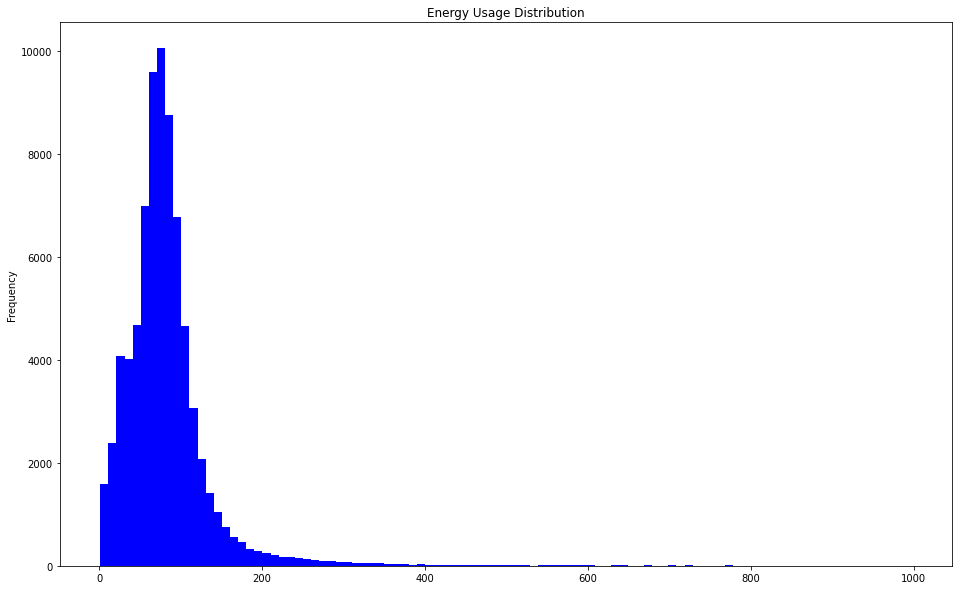

In [6]:
train.site_eui.plot.hist(bins=100,color='blue',title ='Energy Usage Distribution',figsize=(16,10))
print(' ')

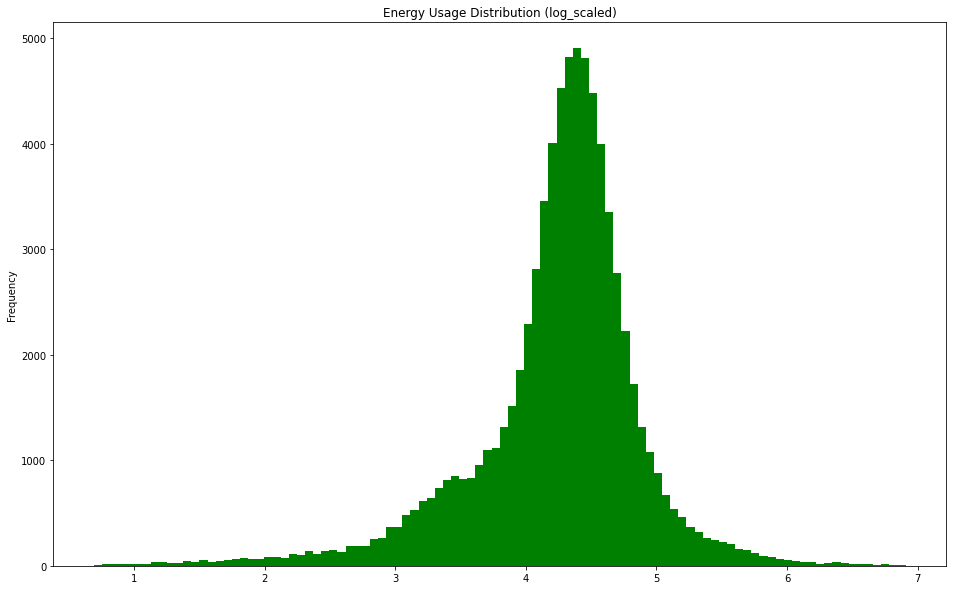

In [7]:
pd.Series(np.log1p(train.site_eui.values)).plot.hist(bins=100,color='g',title ='Energy Usage Distribution (log_scaled)',figsize=(16,10))
print(' ')

**Distribution of average temp**

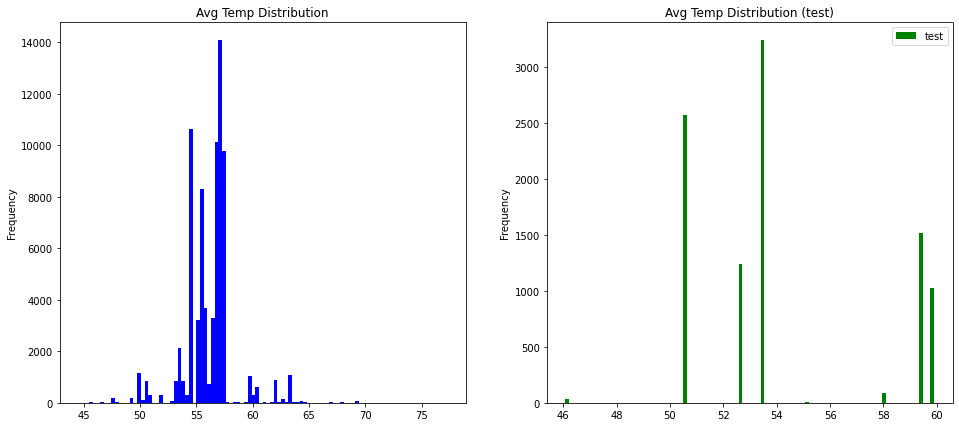

In [8]:
fig,ax=plt.subplots(1,2,figsize=(16,7))

train.avg_temp.plot.hist(ax=ax[0],bins=100,color='blue',title ='Avg Temp Distribution',label='train')

test.avg_temp.plot.hist(bins=100,color='green',title ='Avg Temp Distribution (test)',ax=ax[1],label='test')

plt.legend()
plt.show()

# Preprocessing Pipelines

**Preprocessing steps**

* seperate data into features, target and Id columns
* encode commercial properties as 1 , residential as 0
* Drop Empty columns with missing values > given threshold
* Split the data into train , test
* specify categorical and numerical values seperately , preprocess seperately
* impute missing categoricals using 'constant' strategy
* Impute missing numerical columns with iterative imputer 
* count the number of instances(number of cols) where a point is outlier for numerical columns
* cluster the numerical columns using GMM , append the column to list of categorical columns


**seperate features,target and ID cols**

In [9]:
def transform_target(y):
    '''adding 1 to y and log scale target features.'''
    return np.log1p(y)

def inverse_transform_target(y):
    '''inverse transform log 1p scaled target features'''
    return np.exp(y) - 1

In [10]:
# seperate ids and target cols

cfg.train_ids = train.pop(cfg.id_col)
cfg.test_ids = test.pop(cfg.id_col)


#target
y = train.pop(cfg.target)
y = transform_target(y)   # log scale


building_class_dict = {'Commercial': 1,
                       'Residential': 0}

# replace values with 1/0
train['building_class'].replace(building_class_dict,inplace=True)
test['building_class'].replace(building_class_dict,inplace=True)

**split into train/val set**

In [11]:
def split_data(X,y,test_size=0.1):
    '''split data into train and test set'''
    x_train,x_test,y_train,y_test = train_test_split(X,y,test_size= test_size)
    
    for df in [x_train,x_test,y_train,y_test]:  # reset index
        df.reset_index(drop=True,inplace=True)
    
    return x_train,x_test,y_train,y_test

In [12]:
x_train,x_val,y_train,y_val = split_data(X=train,y=y,test_size=0.1)

print(f' training shape {x_train.shape} \n test shape {x_val.shape}')

 training shape (68181, 62) 
 test shape (7576, 62)


In [13]:
# drop empty cols
def drop_columns(df,
                 columns_list):
    '''drop given columns'''
    return df.drop(columns_list,axis=1)

def drop_empty_columns(df,
                       drop_cols=None,
                       threshold=None):
    '''drop columns with null values greater than given % threshold value'''
    
    if threshold :
        null = (df.isnull().sum() / len(df)) * 100  # % empty 
        drop_cols = null[null.values > threshold].index.to_list()     # select columns to be dropped
        df = drop_columns(df,
                          columns_list=drop_cols)
        cfg.dropped_columns = drop_cols
        
    else:
        df = drop_columns(df,columns_list=cfg.dropped_columns)
        
        
#     print(df.head(10))
    return df 
        

In [14]:
def column_types(df):
    cfg.categorical = df.select_dtypes(include = 'object').columns.to_list()
    cfg.numerical = df.select_dtypes(exclude = 'object').columns.to_list()
    
    return None

**Imputation**

In [15]:
def return_df(array,columns):
    '''return a pd dataframe after a transform'''
    return pd.DataFrame(array,columns=columns)

def iterative_imputer(train,val,test,params={}):
    '''iterative imputation for numerical cols'''
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer
    
    
    
    imp = IterativeImputer(**params)
    
    
    train[cfg.numerical] = return_df(imp.fit_transform(train[cfg.numerical]),
                                                        columns=cfg.numerical)
    
    test[cfg.numerical] = return_df(imp.fit_transform(test[cfg.numerical]),
                                                        columns=cfg.numerical)
    
    
    val[cfg.numerical] = return_df(imp.fit_transform(val[cfg.numerical]),
                                                    columns=cfg.numerical)

    return None


def categorical_imputer(train,val,test):
    '''impute missing values in categorical cols with constant(missing)'''
    
    imp = SimpleImputer(strategy = 'constant', fill_value = 'missing')
    
    train[cfg.categorical] = return_df(imp.fit_transform(train[cfg.categorical]),
                                                        columns=cfg.categorical)
    
    test[cfg.categorical] = return_df(imp.fit_transform(test[cfg.categorical]),
                                                        columns=cfg.categorical)
    
    
    val[cfg.categorical] = return_df(imp.fit_transform(val[cfg.categorical]),
                                                    columns=cfg.categorical)
    
    return None

    

**outliers in numerical data**

In [16]:
def specify_outliers(train,val,test):    
    '''count of variables in which a particular item(row) is a outlier.'''
    train['Is_outlier']=0
    test['Is_outlier']=0
    val['Is_outlier']=0
    for col in cfg.numerical: #iterate over numerical cols
                
        
        Q1=np.percentile(train[col],25)
        Q3=np.percentile(train[col],75)
        
        col_IQR = Q3-Q1
        
        lower_limit= Q1 - (1.5 * col_IQR)
        upper_limit= Q3 + (1.5 * col_IQR)
        
        outliers_idx=list(np.where(train[col]>upper_limit))  
        outliers_idx.extend(np.where(train[col]<lower_limit))
        
        test_outlier_idx=list(np.where(test[col]>upper_limit))
        test_outlier_idx.extend(list(np.where(test[col]<upper_limit)))
        

        val_outlier_idx=list(np.where(val[col]>upper_limit))
        val_outlier_idx.extend(list(np.where(val[col]<upper_limit)))

        for i in outliers_idx:
            train.loc[i,'Is_outlier'] += 1
        
        for i in test_outlier_idx:
            test.loc[i,'Is_outlier'] += 1
            
        for i in val_outlier_idx:
        
            val.loc[i,'Is_outlier'] += 1

            
    return None
    

**Clustering the numerical data**

    The strategy is to cluster based on three features,1) temperature features 2) precipitation and snowfall 3) other "day" features

In [17]:
# K means
#finding ideal k by elbow method:

# def find_ideal_k(m=15,df,cols):
#     '''find ideal k for clustering using elbw method'''
    
    
#     X_temp=scale(df[cols].copy())
#     inertia=[]
#     K=[i for i in range(2,m)]
#     for k in K:
#         km=KMeans(n_clusters=k)
#         km.fit(X_temp)
#         inertia.append(km.inertia_)
    
#     plt.figure(figsize=(16,8))
#     plt.plot(K,inertia)
#     plt.xlabel('K')
#     plt.ylabel('inertia')
#     plt.show()
    
#     del X_temp;gc.collect()
    
    # def kmeans_cluster(train,test,val=None,
#                 cluster_feature='kmeans',
#                 columns=None,
#                 n_components=5,
#                 standardize=True):

In [18]:

    
    
def gmm_cluster(train,val,test,
                cluster_feature='gmm',
                columns=None,
                n_components=5,
                standardize=True):
    '''clutser the given column fields using gaussian mixture models'''
    
    if standardize:
        scaler = StandardScaler()

        tr_scaled = scaler.fit_transform(train[columns])
        ts_scaled = scaler.transform(test[columns])
        val_scaled = scaler.transform(val[columns])

            
    
    gmm = GMM(n_components= n_components,
              max_iter=1000)
    
    train[cluster_feature] = gmm.fit_predict(tr_scaled)
    test[cluster_feature] = gmm.predict(ts_scaled)
    val[cluster_feature] = gmm.predict(val_scaled)
    
    
    return None

def get_clusters(train,test,val):
    '''cluster data'''
    #     1) temp clusters
    temp_cols = [c for c in train.columns if 'temp' in c] 
    _ =gmm_cluster(train,val,test,
                cluster_feature='temp_cluster',
                columns=temp_cols,
                n_components=5,
                standardize=True)
    
    cfg.categorical.append('temp_cluster')
    
    #     2) other climate / geo data 
    clm_cols = ['ELEVATION','snowdepth_inches','snowfall_inches','precipitation_inches'] 
    _ =gmm_cluster(train,val,test,
                cluster_feature='clm_cluster',
                columns=clm_cols,
                n_components=5,
                standardize=True)
    
    
    cfg.categorical.append('clm_cluster')
    
    #     3) days data 
    days_cols =  [c for c in train.columns if 'days' in c] 
    _ =gmm_cluster(train,val,test,
                cluster_feature='d_cluster',
                columns=days_cols,
                n_components=5,
                standardize=True)
    
    
    cfg.categorical.append('d_cluster')
    
    
    return None

**Transformation function**

In [19]:
def numerical_transform(train,val,test):
    '''transformations for numerical columns'''
    
    # convert year buuild to difference between least value and year build
    train['year_built'] = train['year_built'].apply(lambda x: max(x -1600,0))
    val['year_built'] = val['year_built'].apply(lambda x: max(x -1600,0))
    test['year_built'] = test['year_built'].apply(lambda x: max(x -1600,0))
    
    #impute missing with iterative imputer
    _ = iterative_imputer(train,test,val)
    
        
    #count outliers in each feature
    _ = specify_outliers(train,test,val)
    
    #cluster features 
    _ = get_clusters(train,test,val)
    
    
def categorical_transform(train,val,test):
    '''transformations to be applied on categorical data.'''
    
    # impute missing with constant 
    _=categorical_imputer(train=train,test=test,val=val)
    
    return None

**Preprocessing function**

In [20]:
class preprocessor:
    def __init__(self,train,val,test):
        self.X = train.copy(deep=True)
        self.X_val = val.copy(deep=True)
        self.test = test.copy(deep=True)
    
    def transform(self):
        '''apply preprocessing transformations'''
        
        # dropping null columns 
        self.X = drop_empty_columns(self.X,threshold = 50)
        self.test = drop_empty_columns(self.test,threshold = None)
        self.X_val = drop_empty_columns(self.X_val,threshold = None)
        
        # specify numerical and categorical columns
        column_types(self.X)
        
        #apply numerical transforms
        _ = numerical_transform(train=self.X,
                                test = self.test,
                                val = self.X_val)
        
        #apply categorical transforms
        _ = categorical_transform(train=self.X,
                                test = self.test,
                                val = self.X_val)

        
        return self.X,self.X_val,self.test

**Preprocess inputs**

In [21]:
%%time
x_train,x_val,test = preprocessor(train=x_train,
                                    val=x_val,
                                    test=test).transform()


assert (x_train.shape[1] == x_val.shape[1] == test.shape[1]) , 'Columns do not match'

CPU times: user 1min 44s, sys: 1min 3s, total: 2min 47s
Wall time: 43.9 s


# Simple Feature Selection

In [22]:
# def feature_selection(n_iters):
def mutual_info_reg(x_train,y_train,
                     n_iters=30,
                     include_columns = cfg.numerical,
                     sample_size=len(x_train)//4):
    scores=[]
    n=0
    
    
    
    while n<=n_iters:
        
        sample_idx = x_train.sample(sample_size).index
        x=StandardScaler().fit_transform(x_train.loc[sample_idx,include_columns])

        mir_data=mutual_info_regression(X=x,
                                        y=y_train.iloc[sample_idx],
                                       )
        scores.append(mir_data)
        n+=1
        
        del x ; gc.collect()
        
    mean_score=np.mean(a=np.array(scores),
                       axis=0)
    
    mutual_info=pd.DataFrame({'mutual_info':mean_score,
                              'cols':include_columns}).sort_values(by='mutual_info',ascending=False)
    
    
    
    
    return mutual_info

CPU times: user 15min 56s, sys: 2min 52s, total: 18min 48s
Wall time: 18min 49s


<AxesSubplot:title={'center':'Mutual Info Scores'}, ylabel='cols'>

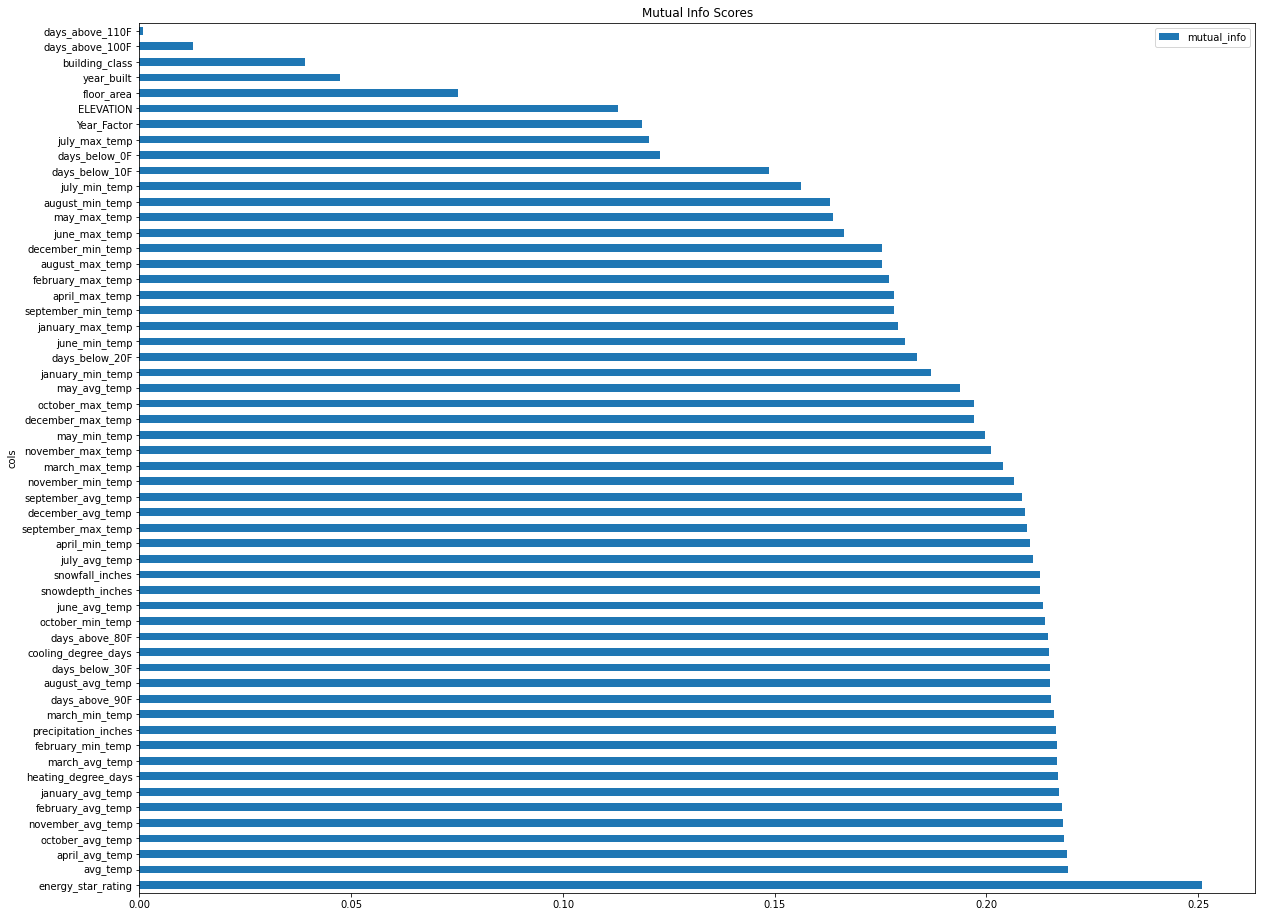

In [23]:
%%time
mir=mutual_info_reg(x_train,y_train,
                    n_iters=30) # find feature importances

mir.plot.barh(x = 'cols',y='mutual_info',figsize=(20,16),title='Mutual Info Scores')

# Hyperparam optimization

In [26]:
class catboost_optimization:
    def __init__(self,
                 X,
                 y,
                 params=None,
                 categorical = cfg.categorical,
                 seed=cfg.seed):
        self.params = params
        self.seed   = seed
        self.categorical = categorical
        self.X = X
        self.y = y
        

    def objective(self,
                  trial:optuna.Trial):
        
        
        
        self.params = {
                'verbose'        : 1,
               'loss_function'  :'RMSE',
               'depth'          :trial.suggest_int('depth',4,12),
               'learning_rate'  :trial.suggest_loguniform('learning_rate', 1e-4, 6e-1),
               'l2_leaf_reg'    :trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),
               'random_strength':trial.suggest_uniform('random_strength',1e-2,0.5),
               'max_bin'        :trial.suggest_int('max_bin',64,254),
               'grow_policy'    :trial.suggest_categorical('grow_policy',
                                                           ['SymmetricTree','Depthwise']),
               'iterations'     :trial.suggest_int('iterations',1000,2000),
#                'max_leaves'     :trial.suggest_int('max_leaves',2,64),
               "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.3, 0.7),
#                "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
               "bootstrap_type": trial.suggest_categorical("bootstrap_type",
                                                           ["Bayesian", "MVS",'Bernoulli']),
               'eval_metric': 'R2'
                }

        #splitting training data 
        x_tr,x_ts,y_tr,y_ts=train_test_split(self.X,
                                             self.y,
                                             random_state=self.seed,
                                             train_size=0.80)
        
# `
        try:
            model = CatBoostRegressor(**self.params)
            
            model.fit(x_tr,y_tr,
                     eval_set=[(x_ts,y_ts)],
                     verbose=0,
                     cat_features=self.categorical,
                     early_stopping_rounds=300)
  

            preds=model.predict(x_ts)

            acc= mean_squared_error(y_ts,preds)

            return acc

        except Exception as e:
            print(e)
            return None
   
    def get_best_params(self,
                        n_trials = 30,
                        time_out=9000,
                        direction= 'minimize'):
        
        print(f'Running optimization for {time_out} seconds / {n_trials} Trials')
        
        
        sampler = optuna.samplers.TPESampler(seed=self.seed)  # Make the sampler behave in a deterministic way.

        self.study=optuna.create_study(direction=direction,
                                        sampler=sampler)
        self.study.optimize(self.objective,
                           n_trials=n_trials,
                           timeout=time_out)

        print("Number of finished trials: {}".format(len(self.study.trials)))

        return self.study.best_trial.params

    def plot_history(self):
        '''plot optimization history :
        credits : https://medium.com/databulls/tps-mar21-leaderboard-14-xgb-catboost-lgbm-optuna-cdffb5124368'''
        optuna.visualization.plot_optimization_history(self.study)
        
    def plot_param_importances(self):
        '''plot param imp'''
        optuna.visualization.plot_param_importances(self.study)

In [ ]:
catb_optimizer = catboost_optimization(X=x_train,
                                   y=y_train,
                                   )


best_params = catb_optimizer.get_best_params(n_trials = 70,
                                            time_out=9000,
                                            direction= 'maximize')  # run hyperparam optimization

[I 2022-02-26 19:10:33,471] A new study created in memory with name: no-name-03b2eeea-c08b-494a-ae76-bbccb9e8b352


Running optimization for 9000 seconds / 70 Trials


[I 2022-02-26 19:10:50,517] Trial 0 finished with value: 0.19608203574784844 and parameters: {'depth': 4, 'learning_rate': 0.08844049407284334, 'l2_leaf_reg': 0.2066463288698664, 'random_strength': 0.3644979371371612, 'max_bin': 250, 'grow_policy': 'SymmetricTree', 'iterations': 1072, 'colsample_bylevel': 0.40737559204074847, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.19608203574784844.
[I 2022-02-26 19:11:53,052] Trial 1 finished with value: 0.3695197490733469 and parameters: {'depth': 7, 'learning_rate': 0.00017746695247452705, 'l2_leaf_reg': 0.07318748070568248, 'random_strength': 0.4557008285826107, 'max_bin': 104, 'grow_policy': 'Depthwise', 'iterations': 1024, 'colsample_bylevel': 0.540219566985649, 'bootstrap_type': 'Bayesian'}. Best is trial 1 with value: 0.3695197490733469.


In [ ]:
best_params.update({'iterations':2500,
                    'verbose':0})

cfg.best_params = best_params

best_params

# Model fitting and prediction 

In [ ]:
class my_estimator:
    def __init__(self,
                 estimator):
        self.estimator_obj = estimator
        self.estimator_list = []
        
    def fit(self,
            X,
            y,
            params= {},
            categorical=None):
        
        '''fit X,y to the data'''
        
        self.params= params
        self.estimator = self.estimator_obj(**self.params)
        
        if categorical:
            self.estimator.fit(X,y,
                               cat_features = categorical)
        else:
            self.estimator.fit(X,y)
            
        return None
            
    def predict(self,X_test):
        '''predict using estimator'''
        
        if not self.estimator:
            print("Fit the model using 'model.fit(X,y)' first!")
            
        return self.estimator.predict(X_test)
    
    def fit_in_folds(self,
                     X,
                     y,
                     categorical=None,
                     params={},
                     eval_metric = mean_squared_error,
                     cv=KFold(n_splits=10)):
        '''fit multiple models using k-fold cross validation strategy'''
        
        self.params = params
           

        for train_idx,val_idx in cv.split(X,y):

            x_t,x_v=X.iloc[train_idx],X.iloc[val_idx]
            y_t,y_v=y.iloc[train_idx],y.iloc[val_idx]

            self.estimator=self.estimator_obj(**self.params)    


            if categorical:
                self.estimator.fit(x_t,y_t,
                                   cat_features = categorical)
            else:
                self.estimator.fit(x_t,y_t)

            n = 0 
            print('Validation score for fold {} is {}'.format(n,eval_metric(y_v,self.estimator.predict(x_v))))
            
            print(f'fitted on {n+1} folds')
                        
            n+=1

            self.estimator_list.append(self.estimator) # store fitted models

        return None

    def predict_in_folds(self,
                         X_test):
        
        if len(self.estimator_list) <1:
            print("Fit the data on multiple folds by calling 'model.fit_in_folds(X,y)' ")
        else:
            predictions_list = []
            for model in self.estimator_list:
                pred = model.predict(X_test)
                
                predictions_list.append(pred)
                
            predictions = np.array(predictions_list).T  # (n,m) dim array, where n is number of examples and m is number of models
        
        
        return predictions
            
    def aggregate_predictions(self,
                              predictions,
                              agg='mean'):
        '''aggregate predictions'''
        
        if agg == 'mean':
            return predictions.mean(axis=1)
        elif agg == 'median':
            return np.median(a= predictions,
                             axis=1)
        else:
            print("assign 'agg' to either of ['mean','median']")
            
            return None
            

**Fitting model**

In [ ]:
%%time

estimator = my_estimator(estimator=CatBoostRegressor)


estimator.fit_in_folds(X = x_train,y = y_train,
                      categorical=cfg.categorical,
                      params=cfg.best_params,
                      eval_metric = mean_squared_error,
                      cv=KFold(n_splits=7))


In [ ]:
# prediction on validation data
predictions_val = estimator.predict_in_folds(X_test = x_val)


#get mean value of predictions
mean_pred_val = estimator.aggregate_predictions(predictions = predictions_val,
                                                agg='mean')
print(f'R2 score of mean value pred on test set is {r2_score(y_val,mean_pred_val)}')

#get median value of predictions
med_pred_val = estimator.aggregate_predictions(predictions = predictions_val,
                                                agg='median')
print(f'R2 score of median value pred on test set is {r2_score(y_val,med_pred_val)}')

# Predictions on test set 

In [ ]:
test_pred = estimator.predict_in_folds(X_test = test)

mean_test = estimator.aggregate_predictions(predictions = test_pred,
                                                agg='mean')

med_test = estimator.aggregate_predictions(predictions = test_pred,
                                                agg='median')

In [ ]:
#inv transforming target (inverse of log1p transforms)

test_mean_pred = inverse_transform_target(mean_test)
test_med_pred = inverse_transform_target(med_test)

# Submissions

In [ ]:
sub1 = pd.DataFrame({'id':cfg.test_ids,
                     'site_eui':test_mean_pred})


sub1.to_csv('submission_1.csv',
            index=False)

In [ ]:
pd.Series(sub1.site_eui.values).plot.hist(bins=100,color='g',title ='Energy Usage Distribution predicted (mean)',figsize=(16,10))
print(' ')

In [ ]:
sub2 = pd.DataFrame({'id':cfg.test_ids,
                     'site_eui':test_med_pred})


sub2.to_csv('submission_2.csv',
            index=False)

In [ ]:
pd.Series(sub2.site_eui.values).plot.hist(bins=100,color='g',title ='Energy Usage Distribution Median Predicted',figsize=(16,10))
print(' ')